## A/B Test Results an e-commerce website



## Table of Contents
- [Introduction](#intro)
- [Part I Wrangle data & Exploratory Data Analysis](#wrangle)
- [Part II A/B Test](#ab_test)
- [Part III Regression](#regression)
- [Conclusion](#conclusion)

<a id='intro'></a>
### Introduction

 For this project, I will be working to understand the results of an A/B test run by an e-commerce website. My goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<img src="Ab-picture.png">

<a id='wrangle'></a>
#### Part I - Wrangle data & Exploratory Data Analysis

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import norm

/Users/hugobritto/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/hugobritto/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/hugobritto/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/hugobritto/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/hugobritto/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Read in the dataset and take a look at the top few rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()
#The total of users is 294,478

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
# check the number of unique users in the dataset.
df.user_id.nunique()

290584

In [5]:
#Check the proportion of users converted
p= df.query('converted == 1').user_id.nunique()/df.shape[0]

print("The proportion of users converted is {0:.2%}".format(p))

The proportion of users converted is 11.94%


In [6]:
# Check the number of times the new_page and treatment don't line up.
l = df.query('(group == "treatment" and landing_page != "new_page" ) \
         or (group != "treatment" and landing_page == "new_page")').count()[0]
print("The number of times the new_page and treatment don't line up is {}".format(l))

The number of times the new_page and treatment don't line up is 3893


In [7]:
#Check missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

#### Note
For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we can not be sure if this row truly received the new or old page. So, I will drop these rows and create a new dataframe.  

In [8]:
df2 =df.drop(df.query('(group == "treatment" and landing_page != "new_page" ) \
                      or (group != "treatment" and landing_page == "new_page") or (group == "control" and landing_page != "old_page") or (group != "control" and landing_page == "old_page")').index)

In [9]:
# Double Check all of the correct rows were removed 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
#Check the number of unique user_ids are in df2
df2.user_id.nunique()

290584

In [11]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


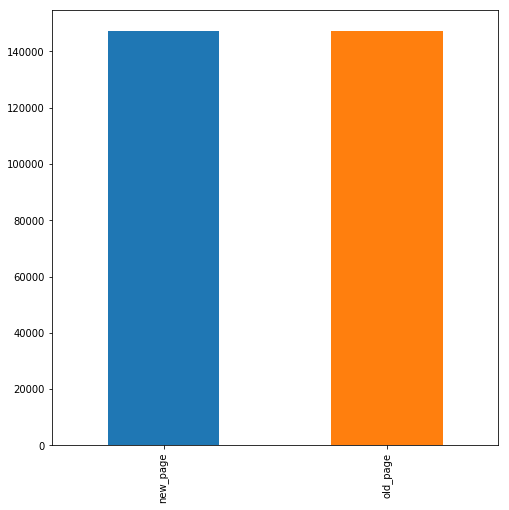

In [16]:
df['landing_page'].value_counts().plot(kind='bar', figsize=(8,8));

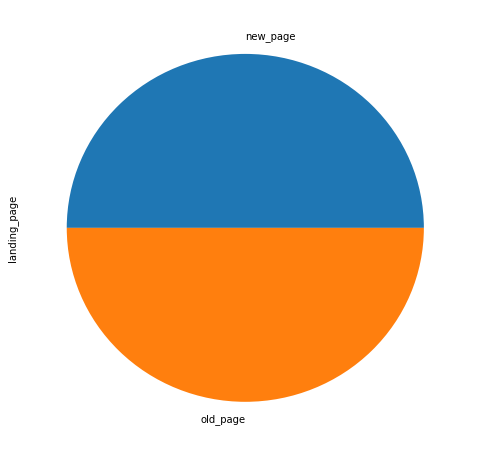

In [17]:
df['landing_page'].value_counts().plot(kind='pie', figsize=(8,8));

([<matplotlib.axis.XTick at 0x1c2654ad68>,
 <a list of 2 Text xticklabel objects>)

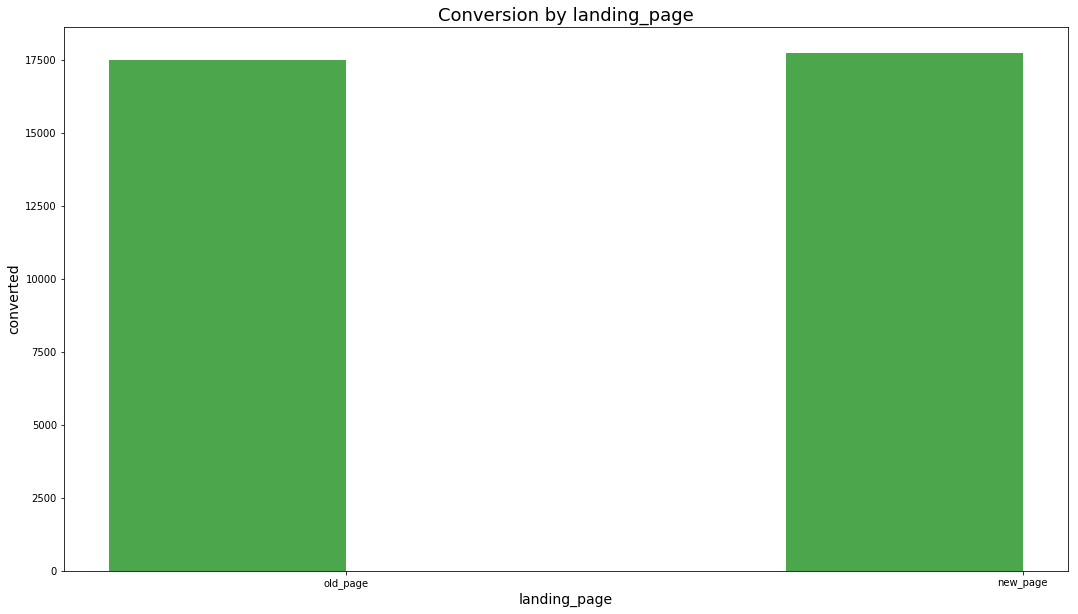

In [80]:
lan_rev =df.groupby('landing_page').sum()['converted']

ind = np.arange(len(lan_rev))  # the x locations for the groups
width = 0.35  

plt.subplots(figsize=(18,10))
gen_bars =plt.bar(ind, lan_rev, width, color='g', alpha=.7)
#adv_bars =plt.bar(ind, adv, width, color='b', alpha=.7, label="Adventure")
plt.ylabel('converted',size=14) # title and labels
plt.xlabel('landing_page',size=14)
plt.title('Conversion by landing_page',size=18)
locations = ind + width / 2  # xtick locations
labels = ['old_page', 'new_page']  # xtick labels
plt.xticks(locations, labels)

In [12]:
#Check duplicates rows
df2.user_id.duplicated().sum()

1

In [13]:
#Check the repeated user_id
df2[df2.duplicated(['user_id'],keep=False)]['user_id']
print("The user_id repeated is 773192")

The user_id repeated is 773192


In [14]:
# Check the row information for the repeat user_id
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [15]:
#Remove the duplicated rows
df2 = df2.drop(df2.query('user_id == 773192 and timestamp == "2017-01-09 05:37:58.781806"').index)

In [16]:
#Check if there is any repeated user_id 
df2.user_id.duplicated().sum()

0

In [17]:
# Calculate the probability of an individual converting regardless of the page they receive
df_prob =df2.query('converted == 1').user_id.nunique()/df2.user_id.nunique()
df_prob

print("The probability of an individual converting regardless of the page they receive is {0:.2%}".format(df_prob))

The probability of an individual converting regardless of the page they receive is 11.96%


In [18]:
# Calculate the probabilty the individual was in the control group to convert
p_cont = df2.query('converted == 1 and group == "control"').user_id.nunique() \
/df2.query('group == "control"').user_id.nunique()

print("The probability they converted based on control group is {0:.2%}".format(p_cont))

The probability they converted based on control group is 12.04%


In [19]:
# Calculate the probabilty the individual was in the treatment group to convert
p_treat = df2.query('converted == 1 and group == "treatment"').user_id.nunique() \
/df2.query('group == "treatment"').user_id.nunique()

print("The probability they converted based on treatment group is {0:.2%}".format(p_treat))

The probability they converted based on treatment group is 11.88%


In [20]:
# Calculate the probabilty that an individual received the new page
p_n = df2.query('landing_page == "new_page"').user_id.nunique()/df2.user_id.nunique()
#The probability that an individual received the new page is 50.00%
print("The probability that an individual received the new page is {0:.2%}".format(p_n))

The probability that an individual received the new page is 50.01%


### Probability results
>It seems to be that there is insufficient evidence to say that the new treatment page leads to more conversions than the control page. The difference of probability between control (12.04%) and treatment groups (11.88%) is tiny, especially when we compare them with the probability of individual conversion (11.96%)

<a id='ab_test'></a>
### Part II - A/B Test

Since we do not have  sufficient evidence to say that the new treatment page leads to more conversions than the control page with probability tests, I will run a hypothesis test continuously as each observation was observed with the time stamp associated with each event. 
 
`1.`I will consider making the decision only based on all the data provided. Further, I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. The null and alternative hypotheses follow below:

> $$H_0:  P_{new} - P_{old}  \leq  0$$


> $$H_1: P_{new} - P_{old} > 0$$

`2.` I will assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page -- that is $p_{new}$ and $p_{old}$ are equal. Furthermore, I will assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I wil use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

I will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

In [21]:
# Since P_new and P_old both have "true" success rates equally, their converted rate 
#will have the same result.
p_new = df2.converted.mean()

print("The convert rate for p_new under the null is {0:.4}".format(p_new))

The convert rate for p_new under the null is 0.1196


In [22]:
# Since P_new and P_old both have "true" success rates equally, their converted rate 
#will have the same result.
p_old = df2.converted.mean()

print("The convert rate for p_old under the null is {0:.4}".format(p_old))

The convert rate for p_old under the null is 0.1196


In [23]:
# Count the total unique users with new page
n_new = df2.query('landing_page == "new_page" ').count()[0]
n_new

145310

In [24]:
# Count the total unique users with old page
n_old = df2.query('landing_page == "old_page" ').count()[0]
n_old

145274

In [25]:
#Simulate n_new transactions with a convertion rate of  p_new under the null. 
#Store these n_new 1's and 0's in new_page_converted

new_page_converted = np.random.choice([0,1],n_new, p=(p_new,1-p_new))
new_page_converted

array([0, 1, 1, ..., 1, 1, 1])

In [26]:
#Simulate n_new transactions with a convert rate of  p_old under the null. 
#Store these  n_new 1's and 0's in old_page_converted

old_page_converted = np.random.choice([0,1],n_old, p=(p_old,1-p_old))
old_page_converted

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
# Find the difference between p_new and p_old
#For discovering the difference between p_new and p_old, it is necessary to find out the mean 
#of new_page_converted and old_page_converted.
new_page_converted.mean()

0.8819558185947285

In [28]:
old_page_converted.mean()

0.879937222076903

In [29]:
#diff_conv is the difference between p_new and p_old.
diff_conv = new_page_converted.mean() - old_page_converted.mean()
diff_conv

0.002018596517825544

In [30]:
# Simulate 10,000 p_new - p_old values with random binomial

new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

In [31]:
p_diffs = np.array(p_diffs)

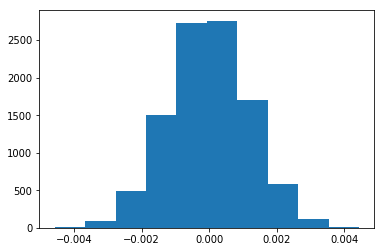

In [32]:
plt.hist(p_diffs);

In [33]:
# Calculate actual difference observed
new_convert = df2.query('converted == 1 and landing_page == "new_page"').count()[0]/n_new
old_convert = df2.query('converted == 1 and landing_page == "old_page"').count()[0]/n_old
obs_diff = new_convert - old_convert
obs_diff

-0.0015782389853555567

In [34]:
#Check the proportion of the p_diffs are greater than the actual difference observed in ab_data.
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

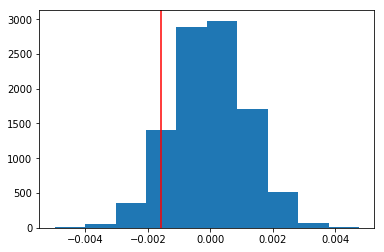

In [35]:
plt.hist(null_vals);
plt.axvline(x=obs_diff, color='red')

In [36]:
(null_vals > obs_diff).mean()

0.9025

#### Sampling distribution analysis

>1- The proportion of the conversion rate differences were greater than the actual observed difference. The p-value is extremely large (90%) than the type I error rate (5%).That means we fail to reject the null hypothesis.  

>**2- According to Wikipedia, p-value is the probability for a given statistical model that, when the null hypothesis is true, the statistical summary (such as the sample mean difference between two compared groups) would be the same as or of greater magnitude than the actual observed results.**

>3- When the p-value is low (in this project less than 5%), it suggests that the null hypothesis is not true, and we need to consider the alternative hypothesis. Finally, the p-value of 90% indicates that the actual page should be maintained.

`3.` Now, I will use  stats.proportions_ztest to compute my test statistic and p-value for evaluating if there is a statistically significance difference in conversion rates of the new page and the conversion rates of the old page.

First, I will calculate the number of conversions for each page, as well as the number of individuals who received each page. The `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [37]:
convert_old = df2.query('converted == 1 and landing_page == "old_page"').count()[0]
convert_new = df2.query('converted == 1 and landing_page == "new_page"').count()[0]
n_old = df2.query('landing_page == "old_page" ').count()[0]
n_new = df2.query('landing_page == "new_page" ').count()[0]

In [38]:
convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

In [39]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),\
                                              np.array([n_new,n_old]), alternative = 'larger')

In [40]:
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [41]:
norm.cdf(z_score)
#0.09494168724097551 # Tells us how significant our z-score is

0.09494168724097551

In [42]:
norm.ppf(1-(0.05/2))
# 1.959963984540054 # Tells us what our critical value at 96% confidence is

1.959963984540054

#### Z-test analysis
>Since the z-score of 1.31 does not exceed the critical value of 1.96, we fail to reject the null hypothesis. The conversion rates of the old page is greater than or equal to the conversion rates of the new. Moreover, there was not a significant difference between the conversion rates of the new page and the conversion rates of the old page (>0.15%).

<a id='regression'></a>
### Part III - A regression approach

In this final part, I will confirm that the result acheived in the previous A/B test can also be acheived by performing logistic regression. I will use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives. <br><br> 

In [43]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [44]:
#Create intercept and dummies columns
df2['intercept'] = 1
df2[['ab_page','old_page']] = pd.get_dummies(df2['landing_page'])
df2 = df2.drop('old_page', axis = 1)

In [45]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [46]:
#Create a model
log = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 23 Aug 2018   Pseudo R-squ.:               8.077e-06
Time:                        19:23:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

#### Regression analysis I
1- The **p-value** associated with ab_page is 0.19 and the **p-value** in **Part II** was 0.90. So, in both cases, we fail to reject the null hyphothesis because these two p-values are greater than 0.05(Type Error I).

2- The difference lies in what each test assumes for their hypothesis. In Part II, the hyphothesis is to analyze if the old page is better unless the new page proves to be definitely greater at a Type I error rate of 5%. In other words,we were concerned with which page had a higher conversion rate, so a one-tailed test. While in the Part III hyphotheses, there is a significant difference in conversion based on which page a customer receives.  The nature of a regression test is not concerned with which had a positive or negative change, specifically. It is concerned with if the condition had any effect at all, so a two-tailed test.

#### Considering other things that might influence whether or not an individual converts.
There are many aspects that may influence whether or not an individual converts. For instance, we could consider factors as country, age, gender, city, hour or weekday and try to understand the correlation between them and the effects under the two groups. Another thing to deal with is the Simpson's paradox, in which a trend appears in several different groups of data, but disappears or reverses when these groups are combined. It is sometimes given the descriptive title of reversal paradox or amalgamation paradox.

#### Regression approach II (add countries)
Now, I will analyze if the countries have an impact on conversion. So, I will along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. I will read in the **countries.csv** dataset and merge together my datasets on the approporiate rows. 

In [47]:
countries_df = pd.read_csv('./countries.csv')

#Merge the countries data frame with df2
df3 = df2.merge(countries_df, on='user_id', how='inner')

In [48]:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [49]:
df3.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [50]:
### Create the necessary dummy variables
df3[['US', 'CA', 'UK']] = pd.get_dummies(df3['country'])
df3 = df3.drop(['country', 'US'], axis = 1)

In [51]:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1


In [52]:
#Print Summary
log2 = sm.Logit(df3['converted'], df3[['intercept','ab_page','CA','UK']])
results2 = log2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 23 Aug 2018   Pseudo R-squ.:               2.323e-05
Time:                        19:23:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA             0.0506      0.028      1.784      0.074      -0.005       0.106
UK             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [53]:
# For better visualizing the coef, we exponentiated them with numpy.
1/np.exp(-0.0149),np.exp(0.0408), np.exp(0.0506)

(1.0150115583846535, 1.0416437559600236, 1.0519020483004984)

#### Regression analysis II

>For each 1 unit decrease in new_page, convert is 1.5 times as likely holding all else constant.

>For each 1 unit increase in CA, convert is 4.1 times as likely holding all else constant.

>For each 1 unit increase in UK, convert is 5.2 times as likely holding all else constant.

Regression approach III (interaction between page and country)

Now, I will look at an interaction between page and country to see if there significant effects on conversion.  

In [54]:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1


In [55]:
#For understanding the interaction between page and country we need two create 
#two columns that multiple ab_page to the country.

df3['CA_new_page']=df3['ab_page']*df3['CA']
df3['UK_new_page']=df3['ab_page']*df3['UK']

In [56]:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,CA_new_page,UK_new_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1,0,0


In [57]:
### Print Summary
log3 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK','CA_new_page','UK_new_page']])

In [58]:
results3 = log3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 23 Aug 2018   Pseudo R-squ.:               3.482e-05
Time:                        19:23:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page        -0.0674      0.052     -1.297      0.195      -0.169       0.034
CA              0.0118      0.040      0.296      0.767      -0.066       0.090
UK              0.0175      0.038      0.465      0.642      -0.056       0.091
CA_new_page     0.0783      0.057      1.378      0.168      -0.033       0.190
UK_new_page     0.0469      0.054      0.872      0.383      -0.059       0.152
===============================================================================
"""

In [59]:
# For better visualizing the coef, we exponentiated them with numpy.
1/np.exp(-0.0674),np.exp(0.0118), np.exp(0.0175),np.exp(0.0783),np.exp(0.0469)

(1.0697232819209153,
 1.011869894648401,
 1.0176540221507617,
 1.0814470441230692,
 1.048017202119183)

#### Regression analysis III

>For each 1 unit decrease in new_page, convert is 1.5 times as likely holding all else constant.

>For each 1 unit increase in CA, convert is 1.2 times as likely holding all else constant.

>For each 1 unit increase in UK, convert is 1.7 times as likely holding all else constant.

>For each 1 unit increase in CA new_page, convert is 8.1 times as likely holding all else constant.

>For each 1 unit increase in UK new_page, convert is 4.8 times as likely holding all else constant.

In [67]:
X = df3[['CA','UK','CA_new_page','UK_new_page']]
y = df3['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [68]:
log_mod = LogisticRegression()
log_mod.fit(X_train, y_train)
preds = log_mod.predict(X_test)
confusion_matrix(y_test, preds)

array([[51154,     0],
       [ 6963,     0]])

In [72]:
accuracy_score(y_test, preds)

0.8801899616291274

<a id='conclusion'></a>
### Conclusion

The work described in this notebook is based on a database providing details on the conversion rate of two groups(treatment group that holds the new page and control group that holds the old page), on an E-commerce platform from 2017-01-02 to 2017-01-24. The goal was to decide whether the E-commerce website should keep the old page or change to a new. 

Regarding the quality of the data, we had only 1 row duplicated in a sample with 294,478 rows. So, that problem did not affect the results.  

To achieve our goal, we performed the following tests: A/B test with z-test and logistic regression models. In A/B test, we found the p-value is higher than type error I, and because this, we fail to reject the null hyphotesis. Then, we saw the z-score was 1.31 which does not exceed the critical value of 1.96, so we fail again to reject the null hyphothesis. 

After that, we used stasmodels to fit the regression model and we found there is a significant difference in conversion based on which page a customer receives. In the first experiment with regression, we analyzed the individual factors of country and page on conversion. 

The coefficient of our explanatory variables presented the following results: For each 1 unit decrease in new_page, conversion is 1.5 times as likely holding all else constant; For each 1 unit increase in CA, conversion is 4.1 times as likely holding all else constant; For each 1 unit increase in UK, conversion is 5.2 times as likely holding all else constant. In the last test we interpreted interaction between page and country to see if there significant effects on conversion, we discovered the following results: For each 1 unit increase in CA new_page, conversion is 8.1 times as likely holding all else constant. For each 1 unit increase in UK new_page, conversion is 4.8 times as likely holding all else constant.

Finally, I strongly recommend gathering more data per period of at least 4 months. I consider the period of 22 days insufficient for making the decision about whether we should keep the old page or change to the new page, even if all tests indicated that we should keep the old one. 